Import Necessary Libs

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

Directories


In [2]:
DATA_DIR = "chest_xray"
TEST_NORMAL = "chest_xray/test/NORMAL"
TRAIN_NORMAL = "chest_xray/train/NORMAL"
VALIDATION_NORMAl = "chest_xray/val/NORMAL"
TEST_PNEUMONIA = "chest_xray/test/PNEUMONIA"
TRAIN_PNEUMONIA = "chest_xray/train/PNEUMONIA"
VALIDATION_NORMAl = "/chest_xray/val/PNEUMONIA"

print("Current working directory:", os.getcwd())

Current working directory: c:\Users\lokes\OneDrive\Desktop\Colorize\pd


Display Random Chest X-ray Images of Normal and Pneumonia Cases

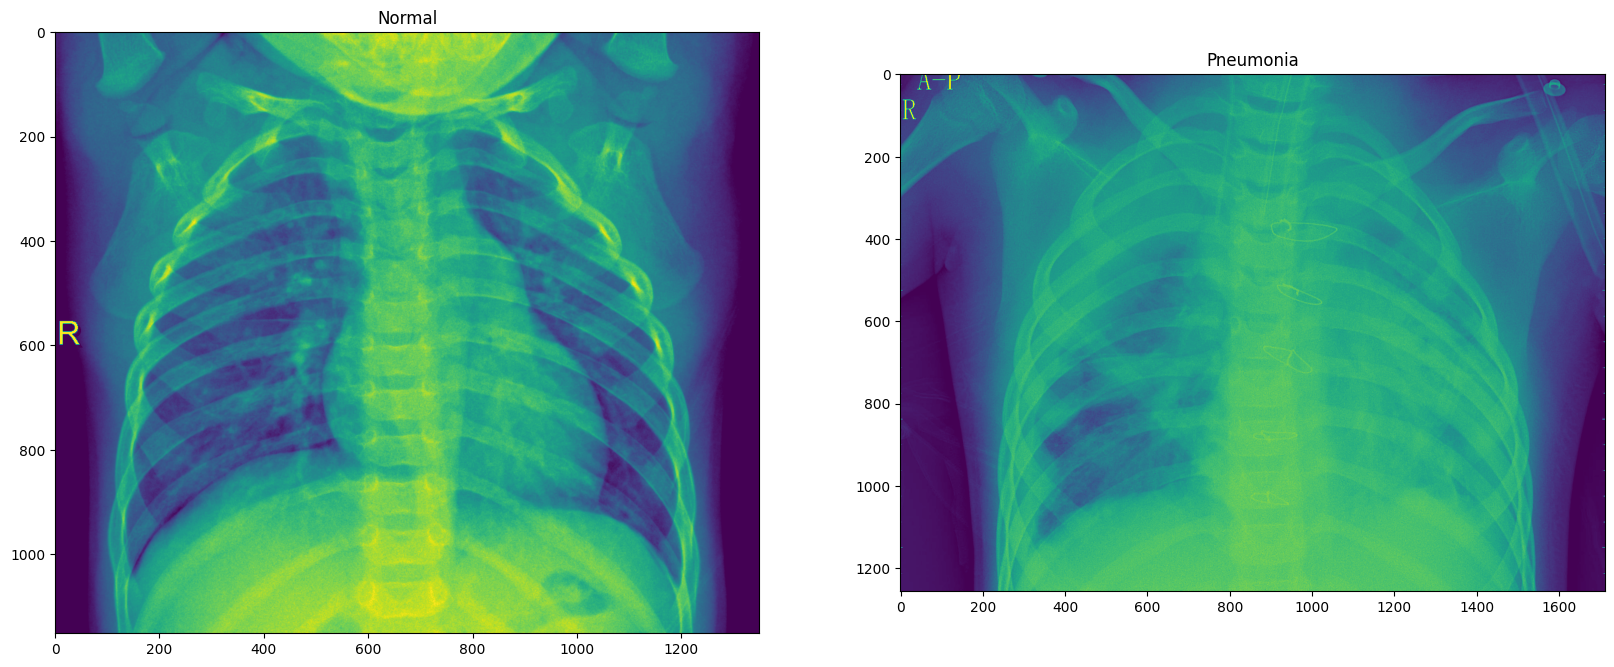

In [12]:
import random
import os
from PIL import Image
import matplotlib.pyplot as plt

# Set the directory paths for normal and pneumonia training images
TRAIN_NORMAL = "chest_xray/train/NORMAL"
TRAIN_PNEUMONIA = "chest_xray/train/PNEUMONIA"

# Choose a random image from the normal and pneumonia directories
random_normal_image = random.choice(os.listdir(TRAIN_NORMAL))
random_pneumonia_image = random.choice(os.listdir(TRAIN_PNEUMONIA))

# Open the selected images
normal_image = Image.open(os.path.join(TRAIN_NORMAL, random_normal_image))
pneumonia_image = Image.open(os.path.join(TRAIN_PNEUMONIA, random_pneumonia_image))

# Create a figure for displaying the images
figure = plt.figure(figsize=(20, 10))

# Display the normal image in the first subplot
subplot1 = figure.add_subplot(1, 2, 1)
plt.imshow(normal_image)
subplot1.set_title("Normal")

# Display the pneumonia image in the second subplot
subplot2 = figure.add_subplot(1, 2, 2)
plt.imshow(pneumonia_image)
subplot2.set_title("Pneumonia")

# Show the figure
plt.show()

Using Adam Optimizer

In [10]:
# Instantiate the Adam optimizer
adam_optimizer = optimizers.Adam(learning_rate=0.001)

Data Generators for Training, Testing, and Validation

In [11]:
train_gen = ImageDataGenerator(shear_range=0.2,horizontal_flip=True,rescale=1.0/255)

test_gen = ImageDataGenerator(rescale=1.0/255)
train_set = train_gen.flow_from_directory(directory="chest_xray/train",
                                                  target_size = (128,128),
                                                  batch_size = 32,
                                                  class_mode="binary")
test_set = test_gen.flow_from_directory(directory="chest_xray/test",
                                                  target_size = (128,128),
                                                  batch_size = 32,
                                                  class_mode="binary")
val_set = test_gen.flow_from_directory(directory="chest_xray/val",
                                                  target_size = (128,128),
                                                  batch_size = 32,
                                                  class_mode="binary")

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [14]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation="relu", input_shape=(128,128,3),name="conv_1.1"))
model.add(Conv2D(32,(3,3),activation="relu",name="conv_1.2"))
model.add(MaxPooling2D((2,2),name="pool_1"))

model.add(SeparableConv2D(64,(3,3),activation="relu",name="conv_2.1"))
model.add(SeparableConv2D(64,(3,3),activation="relu",name="conv_2.2"))
model.add(MaxPooling2D((2,2),name="pool_2"))

model.add(SeparableConv2D(64,(3,3),name="conv_3.1"))
model.add(BatchNormalization(name='bn_3.1'))
model.add(Activation("relu"))
model.add(SeparableConv2D(64,(3,3),activation="relu",name="conv_3.2"))
model.add(MaxPooling2D((2,2),name="pool_3"))

model.add(SeparableConv2D(128,(3,3),name="conv_4.1"))
model.add(BatchNormalization(name='bn_4.1'))
model.add(Activation("relu"))
model.add(SeparableConv2D(128,(3,3),activation="relu",name="conv_4.2"))
model.add(MaxPooling2D((2,2),name="pool_4"))

model.add(Flatten())

model.add(Dense(activation="relu",units=128,
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.7,name="Drop_2"))
model.add(Dense(activation="sigmoid",units=1))

model.compile(optimizer=adam_optimizer,loss = "binary_crossentropy", metrics=["accuracy"])

Model Summary

In [15]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1.1 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1.2 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2.1 (SeparableConv2D)      │ (None, 60, 60, 64)     │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2.2 (SeparableConv2D)      │ (None, 58, 58, 64)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3.1 (SeparableConv2D)      │ (None, 27, 27, 64)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3.1 (BatchNormalization)     │ (None, 27, 27, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3.2 (SeparableConv2D)      │ (None, 25, 25, 64)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4.1 (SeparableConv2D)      │ (None, 10, 10, 128)    │         8,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4.1 (BatchNormalization)     │ (None, 10, 10, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4.2 (SeparableConv2D)      │ (None, 8, 8, 128)      │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_4 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_2 (Dropout)                │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,481 (1.21 MB)

 Trainable params: 316,097 (1.21 MB)

 Non-trainable params: 384 (1.50 KB)

In [17]:
# Define the file path for saving the best model weights
filepath = "weights.best.keras"

# Create a model checkpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# List of callbacks to be used during training
callbacks_list = [checkpoint]

# Train the model using the data generators
xray_model = model.fit(
    train_set,
    steps_per_epoch=163,              # Number of batches of samples to draw from the training generator
    callbacks=callbacks_list,         # List of callbacks to apply during training
    epochs=20,                        # Number of epochs to train the model
    validation_data=test_set,         # Validation data to evaluate the loss and any model metrics at the end of each epoch
    validation_steps=624 // 32        # Number of batches of samples to draw from the validation generator
)

Epoch 1/20


C:\Users\lokes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7609 - loss: 1.2010
Epoch 1: val_accuracy improved from -inf to 0.62336, saving model to weights.best.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.7613 - loss: 1.1976 - val_accuracy: 0.6234 - val_loss: 0.6989
Epoch 2/20

Epoch 2: val_accuracy improved from 0.62336 to 0.68750, saving model to weights.best.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_loss: 0.6457


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9222 - loss: 0.2546
Epoch 3: val_accuracy did not improve from 0.68750
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 519ms/step - accuracy: 0.9223 - loss: 0.2544 - val_accuracy: 0.6234 - val_loss: 0.8366
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.68750
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_loss: 0.6602
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9372 - loss: 0.2129
Epoch 5: val_accuracy did not improve from 0.68750
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 530ms/step - accuracy: 0.9372 - loss: 0.2128 - val_accuracy: 0.6250 - val_loss: 1.0264
Epoch 6/20

Epoch 6: val_accuracy improved from 0.68750 to 0.81250, saving model to weights.best.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.4959
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy

Save the Model

In [19]:
model.save('pneumoniaDetectLV17.h5')


Test Accuracy

In [22]:
test_accu = model.evaluate(test_set,steps=624//32)
test_accu

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.8252 - loss: 0.6622


[0.6880678534507751, 0.8009868264198303]

In [42]:
import numpy as np
from PIL import Image

def calculate_threshold(image_path):
    # Open the image
    img = Image.open(image_path)

    # Convert the image to grayscale
    grayscale_img = img.convert('L')

    # Convert the grayscale image to a NumPy array
    img_array = np.array(grayscale_img)

    # Calculate the mean pixel intensity value
    mean_intensity = np.mean(img_array) / 255.0  # Normalize to range [0, 1]

    return mean_intensity

# Example usage:
image_path = 'chest_xray/test/NORMAL/IM-0001-0001.jpeg'
threshold_value = calculate_threshold(image_path)
print(f"Threshold value For x-rays: {threshold_value}")

image_path = r"C:\Users\lokes\Downloads\download2.jpg"
threshold_value = calculate_threshold(image_path)
print(f"Threshold value For x-rays: {threshold_value}")


Threshold value For x-rays: 0.5137200303643611
Threshold value For x-rays: 0.4659596071481318
